# Secrets behind recipes

Team member: Tianyang Dong, Wei Jiang, Huajian Qiu, Jiahua Wu

---
## 0 Import libraries and recipe dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import inflect
import os

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

In [2]:
recipe = pd.read_csv('data/RAW_recipes.csv')

In [3]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [4]:
# Split the nutrition list
nutritions_list = ["calories(kJ)", "total_fat(g)", "sugar(g)", "sodium(mg)", "protein(g)", "sat_fat(g)", "carbs(g)"]
recipe['nutrition'] = recipe['nutrition'].apply(eval)
recipe[nutritions_list] = pd.DataFrame(recipe.nutrition.values.tolist(), index=recipe.index)
recipe = recipe.drop(['nutrition'], axis=1)

---

# 1 Data cleaning of recipes

## 1.1 Map recipe to countries (regions) and continents

First, drop the rows that have nan values on column 'name'. Since 'description' is irrelavent to our analysis, we will not deal with the missing values in column 'description'.

The information about country/region is extracted from the tags, for example, there are tags like 'american', 'southern-united-states', 'scottish'. These tags will be mapped to countries if they describes a part of a country, e.g. 'southern-united-states' to 'America', otherwise they will be mapped to a region, e.g. 'caribbean' to 'Caribbean'. Later the countries will be mapped to continents. 

Due to the variety of country indicators in the tags (for example 'hunan', 'szchuan' indicate China), nlp libraries like spacy cannot ideally identify and capture the country info, so we choose to parse it manually. The resulting mapping is explicitly defined in utils.py for readability of the notebook.

In the end, we get 96940 rows of recipes with country labeled.

In [506]:
from utils import extract_country

In [507]:
recipe.drop(index = recipe[recipe['name'].isna()].index, inplace = True)

In [508]:
recipe['tags'] = recipe['tags'].apply(eval)

TypeError: eval() arg 1 must be a string, bytes or code object

In [8]:
recipe_tag = recipe.explode('tags')

In [509]:
recipe_country = extract_country(recipe_tag);

In [510]:
len(recipe_country.country.unique())

67

Recipes of 67 countries are identified.

In [511]:
recipe_count = recipe_country.groupby('country').count()[['name']].rename(columns={'name': 'recipes count'}).sort_values(by='recipes count')

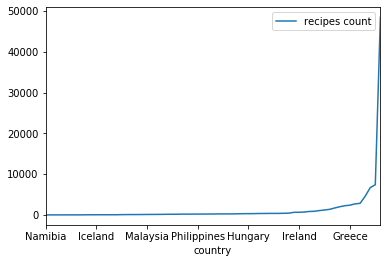

In [512]:
recipe_count.plot()

In [513]:
underrepresented_country_list = recipe_count.head(15).index.tolist()

In [586]:
recipe_country = recipe_country[~recipe_country.country.isin(underrepresented_country_list)]

As we can see, the data is skewed and some countries have too few samples.

## 1.2 Ingredients Cleaning

We notice that in some texts of ingredients there are superfluous descriptive words. For example, for flour there are "buckwheat flour", "all-purpose flour" while they should all be categorized as flour. We identify these adjectives as words that are tagged as "JJ"(adjective) by the nltk library. However, we spot some error in tagging (e.g. bean, cake are tagged as adjective) so we first remove some already known ingredients from the adjective set by opearting set difference with the available ingredient list and then we manually check the remaining words to rectify errors.

Then we employ the lemmatization functionality of spacy library to unify the form of words.

In [469]:
import nltk

In [672]:
# Collection of words tagged as adjective by nltk
s = set()
for ind, ls in enumerate(recipe_country.ingredients.apply(eval)):
    for word in ls:
        tokens = nltk.word_tokenize(word)
        tagged = nltk.pos_tag(tokens)
        s = s.union(set([ele[0] for ele in tagged if ele[1] == 'JJ']))

In [521]:
# List of misclassified words obtained by manual check
wrongly_classified_list = ['acorn', 'adzuki', 'aji', 'amaranth', 'ancho', 'andouille', 'annatto', 'argan', 'astragalus', 'angelica',
               'bean', 'balsamic', 'bison', 'bisquick', 'blackfish', 'bulgur', 'cachous', 'cake', 'canary', 'cantal', 'cauliflow', 
               'chicory', 'chipotle', 'chocolate', 'chive', 'citric', 'claret', 'cornbread', 'couscous', 'crayfish', 
               'crust', 'curd', 'custard', 'dasheen', 'dough', 'espresso', 'fava', 'fajita', 'feta', 'fish', 'flax', 'garbanzo',
               'geese', 'gelatin', 'gingerbread', 'goldfish', 'gravy', 'lactose', 'lasagna', 'lecithin', 'lemonade', 
               'loin', 'lumpfish', 'macaroni', 'marshmallow', 'mastic', 'menudo', 'mesquite', 'mochiko', 'nacho', 'nixtamal'
               ,'noodle', 'nopal', 'nougat', 'nut', 'parmesan', 'pebble', 'pecan', 'peppercorn', 'phyllo', 'pinto', 'pita',
               'pomfret', 'popcorn', 'poppy', 'cornbread-muffin', 'five-spice', 'garlic-chipotle', 'geese', 'gingerbread', 'gruyere', 
               'guacamole', 'gumbo', 'jalapeno', 'oatmeal', 'pecan', 'peppercorn', 'potatoes', 'quorn', 'robin', 'salad', 'sambal',
               'sandwich', 'sauce', 'savory', 'shellfish', 'shortcrust', 'shortbread', 'soup', 'sourdough', 'soy', 'soybean', 'sushi', 
               'taco', 'udon', 'umeboshi', 'vermicelli', 'waffle', 'weisswurst']

In [200]:
seasoning = ['salt', 'sugar','cheese', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vineger','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg']

In [499]:
# The categoreis (dairy, grain, vegetable, fruit, meat, seafood) are collected from supercook (https://www.supercook.com/#/recipes). 
# 220 various ingredients are identified. 
dairy = ['egg', 'milk', 'cream', 'yogurt', 'frosting'] 
grain = ['rice', 'pasta', 'flour', 'bread', 'tortilla', 'pancake', 'pie', 'pizza']
vegetable = ['tomato', 'potato', 'carrot',
              'broccoli', 'corn', 'spinach', 'mushroom', 'beans', 'salad green', 'cucumber',
              'pickle', 'avocado', 'zucchini', 'cilantro', 'frozen vegetable', 'asparagus',
             'cabbage', 'cauliflower', 'kale', 'mixed vegetable', 'pumpkin', 'squash', 'scallion',
             'shallot', 'eggplant', 'beet', 'horseradish', 'leek', 'caper', 'brussels sprout',
             'artichoke', 'chia', 'radish', 'sauerkraut', 'artichoke', 'arugula', 'capsicum',
             'bok choy', 'parsnip', 'okra', 'yam', 'fennel', 'turnip', 'pea', 'seaweed', 'chard', 'collard',
             'pimiento', 'watercress', 'tomatillo', 'rocket' 'bamboo shoot', 'rutabaga', 'endive',
              'jicama',  'kohlrabi', 'palm', 'butternut', 'daikon', 'radicchio', 'porcini', 'jerusalem artichoke'
             'cress', 'chestnut', 'dulse', 'micro green', 'burdock', 'chayote']
fruit = ['lemon', 'apple', 'banana', 'lime', 'strawberry', 'orange', 'pineapple', 'blueberry', 
             'raisin', 'coconut', 'grape', 'peach', 'cranberry', 'mango', 'pear', 'blackberry', 'cherry',
        'watermelon', 'kiwi', 'grapefruit', 'mandarin', 'craisins', 'cantaloupe', 'plum', 'apricot',
         'clementine', 'prune', 'apple butter', 'pomegranate', 'nectarine', 'fig', 'tangerine', 'papaya',
         'rhubarb', 'sultana', 'plantain', 'currant', 'passion fruit', 'guava', 'persimmon', 'lychee',
         'lingonberry', 'tangelo', 'kumquat', 'boysenberry', 'star fruit', 'quince', 'honeydew', 'crabapple']
meat = ['chicken', 'beef', 'bacon', 'sausage', 'steak', 'ham', 'hot dog', 'pork', 'turkey', 'pepperoni',
       'salami', 'spam', 'venison','bologna', 'bratwurst', 'prosciutto', 'lamb', 'pancetta', 'duck', 'veal',
        'cornish hen', 'deer',  'pastrami', 'rabbit', 'elk', 'marrow bone', 'goose', 'quail', 'oxtail',
 'pheasant', 'moose', 'foie gra', 'boar', 'snail', 'pigeon', 'grouse', 'ostrich', 'soppressata', 'alligator']
seafood =  ['tuna', 'salmon', 'tilapia', 'fish fillets', 'cod', 'anchovy', 'sardine', 'whitefish',
            'halibut', 'trout', 'haddock', 'flounder', 'catfish', 'mahi mahi', 'mackerel', 'sole', 'sea bass',
            'red snapper', 'swordfish', 'pollock', 'herring', 'perch', 'grouper', 'caviar', 'monkfish', 
            'rockfish', 'pike', 'barramundi', 'eel', 'bluefish', 'carp', 'cuttlefish', 'pompano', 'arctic char',
            'john dory', 'marlin', 'amberjack', 'sturgeon', 'shrimp', 'crab', 'prawn', 'scallop', 'clam',
            'lobster', 'mussel', 'oyster', 'squid', 'calamari', 'crawfish', 'octopus', 'cockle', 'conch',
            'sea urchin']
unions = dairy + vegetable + fruit + meat + seafood + grain

In [524]:
adj_to_be_removed = list(s.difference(set(unions + seasoning + wrongly_list + seperate)))

In [646]:
# Add some more adjective observed in the word cloud image
# Ground is the past participle of grind
adj_to_be_removed += ['ground']

In [896]:
# Remove adjectives from the column of ingredients defined above
# nltk fails to identify adjective in form of present and passed participle thus we remove it here.
def remove_adj(ls):
    for ind, string in enumerate(ls):
        ls[ind] = ' '.join(list(filter(lambda x: x not in adj_to_be_removed 
                                       and not x.endswith('ing') 
                                       and not x.endswith('ed')
                                       and not x.endswith("'s"), string.split())))
    if '' in ls:
        ls.remove('')
    if 'orange, juice of' in ls:
        ls.remove('orange, juice of')
    return ls

In [869]:
recipe_country.ingredients = recipe_country.ingredients.apply(eval).apply(remove_adj)

In [870]:
# In later operation we find some ingredients are connected using 'and' so we split them here
def remove_and(ls):
    for string in ls:
        for prop in ['and', '&']:
            if prop in string:
                ls += string.split(prop)
                ls.remove(string)
    return ls

In [871]:
recipe_country.ingredients = recipe_country.ingredients.apply(remove_and)

In [589]:
import spacy
nlp = spacy.load('en')

In [590]:
# Apply lemmatization to the ingredients
def word_cleaning(ls):
    doc = nlp(str(ls))
    word_seq = []
    for token in doc:
        word_seq.append(token.lemma_)
    return ' '.join(word_seq)

In [591]:
# After reconstruction of lemmatization defined above, some beginning and ending space are introduced in the 
# text and we need to remove them.
def eval_trim(string):
    try:
        return [string.strip() for string in eval(string)]
    except:
        return None

In [592]:
recipe_country.ingredients = recipe_country.ingredients.apply(word_cleaning).apply(eval_trim).apply(remove_adj)

In [847]:
recipe_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96403 entries, 0 to 96402
Data columns (total 19 columns):
name              96403 non-null object
id                96403 non-null int64
country           96403 non-null object
continent         95435 non-null object
minutes           96403 non-null int64
contributor_id    96403 non-null int64
submitted         96403 non-null object
n_steps           96403 non-null int64
steps             96403 non-null object
description       94047 non-null object
ingredients       96403 non-null object
n_ingredients     96403 non-null int64
calories(kJ)      96403 non-null float64
total_fat(g)      96403 non-null float64
sugar(g)          96403 non-null float64
sodium(mg)        96403 non-null float64
protein(g)        96403 non-null float64
sat_fat(g)        96403 non-null float64
carbs(g)          96403 non-null float64
dtypes: float64(7), int64(5), object(7)
memory usage: 14.0+ MB


In [594]:
recipe_country = recipe_country.dropna(subset=['ingredients']).reset_index(drop=True)

In [874]:
recipe_country.to_csv('ingredients_processed.csv')

## 1.2 Classify recipes by meal types

To better understand the difference between countires and regions, we divide the recipes into classes: main dish, side dish, dessert, appetizer, soup, beverage, cake style (bread, sandwich and cake), sauce, salad and snack. These classes are not mutually exclusive, so there may be a recipe in two classes at the same time. The information about dish type is gained from tags of recipes.

This type specified dataframe will be used later for analyzing the ingredients and answer questions like: what is the most frequently used meat for main dish in each country?

In [16]:
def classify_meal_types(input_recipe):
    meal_type_tags = ['main-dish', 'side-dishes', 'dessert', 'appetizer', 'soup|stew', 
                      'beverage', 'sandwich|bread|cake', 'sauce', 'salad', 'snack']
    return_recipe = input_recipe.copy()
    return_recipe['meal_type'] = np.nan
    return_recipe.reset_index(drop=True, inplace=True)
    
    for meal_type in meal_type_tags:
        return_recipe.meal_type.loc[return_recipe['tags'].str.contains(meal_type)] = meal_type
    return_recipe.meal_type.replace('sandwich|bread|cake', 'cake_style', inplace=True)
    return_recipe.meal_type.replace('soup|stew', 'soup', inplace=True)
    return_recipe.dropna(inplace=True)
    return_recipe.reset_index(drop=True, inplace=True)
    return return_recipe

In [17]:
recipe_meal_type = classify_meal_types(recipe_tag)

In [18]:
recipe_meal_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261658 entries, 0 to 261657
Data columns (total 19 columns):
name              261658 non-null object
id                261658 non-null int64
minutes           261658 non-null int64
contributor_id    261658 non-null int64
submitted         261658 non-null object
tags              261658 non-null object
n_steps           261658 non-null int64
steps             261658 non-null object
description       261658 non-null object
ingredients       261658 non-null object
n_ingredients     261658 non-null int64
calories(kJ)      261658 non-null float64
total_fat(g)      261658 non-null float64
sugar(g)          261658 non-null float64
sodium(mg)        261658 non-null float64
protein(g)        261658 non-null float64
sat_fat(g)        261658 non-null float64
carbs(g)          261658 non-null float64
meal_type         261658 non-null object
dtypes: float64(7), int64(5), object(7)
memory usage: 37.9+ MB


## 1.3 Extract seasoning for each recipe

In the column 'ingredients', all the ingredients needed in the recipe are listed. To learn in detail about each country's eating habits, we investigate two aspects of the ingredients: seasoning and other ingredients. This classication can be justified by the fact that although seasoning is added in small quantities, it plays an important and sometimes decisive role in the taste of dishes. Therefore its usage can reflect the eating preference of different regions.

In [928]:
recipe_country_ingre = recipe_country.copy()

In [966]:
seasonings = ['salt', 'sugar', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vinegar','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg', 'sauce']

In [967]:
def identify_seasoning(ls):
    res = [string for string in ls if sum(ingredient in string for ingredient in seasonings) > 0]
    if len(res) > 0:
        return res
    return None

In [968]:
recipe_country_ingre['seasoning'] = recipe_country_ingre['ingredients'].apply(identify_seasoning)
recipe_country_ingre.dropna(subset=['seasoning'], inplace=True)
recipe_country_seasoning = recipe_country_ingre.explode('seasoning')

Top 21 frequently used seasoning for each country is computed.

In [969]:
season_country = recipe_country_seasoning.groupby(['country', 'seasoning'])['id'].count().groupby('country').nlargest(21)

In [970]:
season_country = season_country.to_frame().droplevel(0).reset_index()  

In [971]:
# Show frequency of each seasoning
season_country.groupby('seasoning').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'}).tail(25)

,country count
seasoning,
hoisin sauce,2
peanut butter,2
spice,2
buttermilk,2
oyster sauce,2
chili sauce,2
curry paste,1
tarragon,1
vanilla essence,1


In [949]:
season_country.country[season_country['seasoning'] == 'wasabi']

565    Japan
Name: country, dtype: object

In [950]:
season_country.country[season_country['seasoning'] == 'tarragon']

335    France
Name: country, dtype: object

In [956]:
season_country.country[season_country['seasoning'] == 'star anise']

606    Malaysia
Name: country, dtype: object

In [957]:
season_country.country[season_country['seasoning'] == 'rice wine vinegar']

562    Japan
Name: country, dtype: object

In [959]:
season_country.country[season_country['seasoning'] == 'soy sauce']

39        Australia
168           China
383          Hawaii
448       Indonesia
546           Japan
595        Malaysia
687     New Zealand
738     Philippines
781       Polynesia
884     South Korea
972        Thailand
1059        Vietnam
Name: country, dtype: object

Recall that we identify 51 coutries in total. Therefore, as universal flavorings, salt, salt, pepper, onion, oil, sugar and butter almost appear in recipes of all countries studied. In contrast, at the bottom of the sorted list, we may recognize some regional specialties. Used as a pungent condiment for sushi, wasabi is indispensible in most of the japanese recipes. Tarragon is one of the four "fines herbes" of French cooking, and is particularly suitable for chicken, fish, and egg dishes. Mace and herbs are widely used in european cuisine while soy sauce is mostly used in Asia.

#### Here we show the Mexican's top 20 most frequently used seasonings  as an example. Word cloud is a popular tool for showing word frequencies and it is used to visualize the result.

In [752]:
from utils import plt_wordcloud

In [973]:
data = season_country[season_country['country'] == 'China']['seasoning'].values

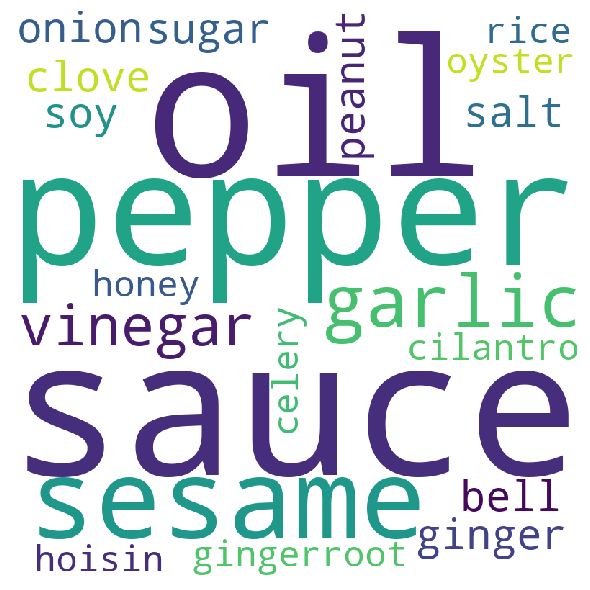

In [974]:
plt_wordcloud(data)

## 1.4 Extract cooking methods for each recipe

Beside the ingredients, cooking method also varies across country. When 'boiling eggs' or 'frying eggs', the ingredients used are the same, yet the look, the smell and the flavor of the dishes are distinct. In this section we extract cooking methods from column 'steps' from the dataframe.

In [756]:
method_list = ['bake', 'barbecue', 'blanch', 'boil', 'braise', 'brine', 'broil', 'caramelize', 
               'crock pot','deglaze','devein','dice','distill','drain','emulsify',
               'fry','grate','griddle','grill','knead','leaven','marinate','mash','microwave',
               'parboil','pickle','poach','pressure cook','puree','roast','saute','scald',
               'scramble','shred','simmer','slow cook','smoke','sous-vide','steam',
               'stew','tenderize','thicken','toast','whip','whisk']

In [757]:
recipe_cooking = recipe_country.copy()

In [758]:
recipe_cooking['steps'] = recipe_cooking['steps'].apply(eval)

In [759]:
def identify_cooking(row):
    r_list = set([])
    for stc in row:
        s_list = re.findall(r"[\w']+", stc)
        for word in s_list:
            if word in method_list:
                r_list.add(word)
    return list(r_list)

In [760]:
recipe_cooking['method'] = recipe_cooking['steps'].apply(identify_cooking)

In [761]:
recipe_cooking.reset_index(drop = True, inplace = True)

In [762]:
recipe_cooking.drop(index = recipe_cooking[recipe_cooking['method'].apply(len) == 0].index, inplace = True)   

In [763]:
recipe_cooking_e = recipe_cooking.explode('method')

In [848]:
# Take out the top 5 used cooking methods in recipes of each country
method_country = recipe_cooking_e.groupby(['country', 'method'])['id'].count().groupby('country').nlargest(20)
method_country = method_country.to_frame().droplevel(0).reset_index()  

In [849]:
# Show frequency of each cooking method in the top-5 method list
method_country.groupby('method').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

,country count
method,
bake,51
drain,51
simmer,51
boil,51
saute,51
fry,51
whisk,50
roast,48
mash,47


In [853]:
method_country.country[method_country['method'] == 'poach']

159    Chile
Name: country, dtype: object

In [854]:
method_country.country[method_country['method'] == 'devein']

569    Malaysia
Name: country, dtype: object

In [857]:
method_country.country[method_country['method'] == 'scramble']

173       China
933    Thailand
Name: country, dtype: object

As the easiest methods, boil, simmer and drain are largely present in recipes of various countries for food cooking. Marinate is commonly used for preprocessing food in asian countries.

#### American cooking method wordcloud

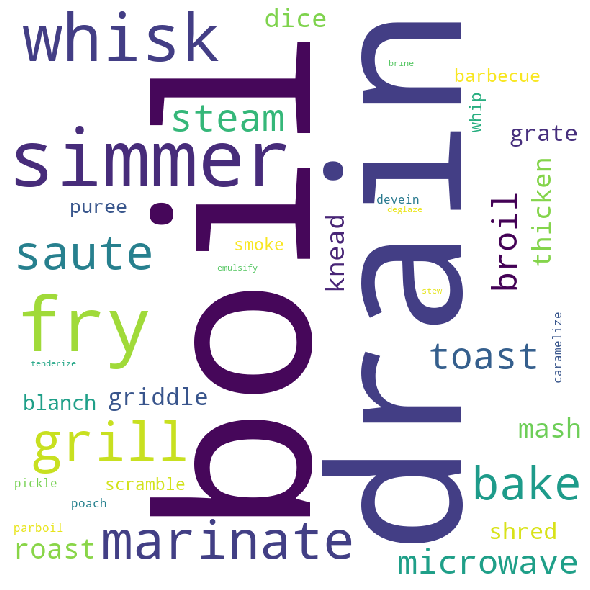

In [781]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'Japan']['method'].values
plt_wordcloud(data)

#### Chinese cooking method wordcloud

In [782]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'China']['method'].values

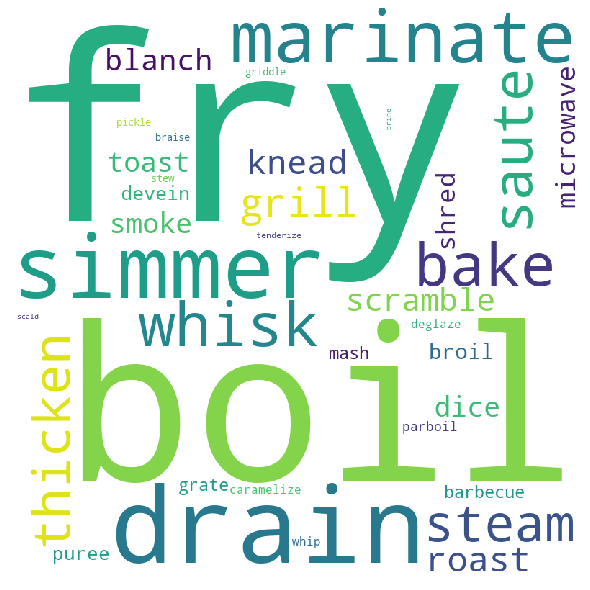

In [783]:
plt_wordcloud(data)

The top 10 most frequenly used cooking methods of American and Chinese are shown in a wordcloud below. The most popular way for Chinese is to fry, which coincides with our expectation. We can see that 'microwave' and 'bake' is not popular in China, because these methods are not traditional Chinese cooking methods. While for Americans, they are used to 'baking' things, and 'fry' will not be their top choice when cooking.

## 1.5 Ingredients Analysis

In [885]:
recipe_country_ingreds = recipe_country.explode('ingredients')

In [886]:
recipe_country_ingreds = recipe_country_ingreds[~recipe_country_ingreds.ingredients.isin(seasoning)]

In [887]:
# Collect the top 10 frequently used ingredients (seasoning removed) in each country
ingredient_country = recipe_country_ingreds.groupby(['country', 'ingredients'])['id'].count().groupby('country').nlargest(10)
ingredient_country = ingredient_country.to_frame().droplevel(0).reset_index()

In [888]:
# Show frequency of each ingredients in the top-10 list
ingredient_country.groupby('ingredients').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'}).head(10)

,country count
ingredients,
water,51
garlic clove,42
egg,41
flour,32
olive oil,26
tomato,26
milk,24
lemon juice,22
cream,21


At the top we can see some universal ingredients such as water, garlic clove and eggs.

In [889]:
# Show frequency of each cooking method in the top-5 method list
ingre_country_count = ingredient_country.groupby('ingredients').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

In [890]:
# We take out "specialties" which are ingredients that only appear in the top-5 list of a particular country
specialites = ingre_country_count[ingre_country_count['country count'] == 1]

In [891]:
# Add country name to the dataframe
country_df = pd.DataFrame({'country':[ingredient_country.country[ingredient_country.ingredients == ingred].tolist()[0] 
            for ingred in specialites.index], 'ingredients': specialites.index.tolist()})

In [892]:
specialites = specialites.reset_index().merge(country_df)

In [893]:
recipe_ingre_count = recipe_main.groupby('ingredients').count().reset_index()

In [894]:
# Add ratio of appearance in dishes of the country
specialites['frequency ratio'] = pd.Series([len(recipe_country_ingreds[(recipe_country_ingreds.country == country) 
                                                                       & (recipe_country_ingreds.ingredients == ingredients)])\
                                            / len(recipe_country[(recipe_country.country == country)]) 
                                             for country, ingredients in zip(specialites.country, specialites.ingredients)])

In [895]:
specialites.sort_values('country', ascending=False)

,ingredients,country count,country,frequency ratio
4,lemongrass,1,Vietnam,0.119658
12,bean sprout,1,Vietnam,0.156695
3,caster sugar,1,United Kingdom,0.105664
6,vanilla extract,1,United Kingdom,0.056645
31,curry paste,1,Thailand,0.197848
22,gruyere cheese,1,Switzerland,0.114667
26,pepper paste,1,South Korea,0.094862
21,mushroom,1,Russia,0.125984
0,cabbage,1,Poland,0.137592
18,kielbasa,1,Poland,0.113022


At the bottom we see many country specialties and just to name a few: parmesan cheese and mozzarella cheese for Italy, feta cheese for Greece, mirin and sake for Japan, sauerkraut for Germany and gruyere cheese for Switzerland. 

These particular ingredients appear in more than 10% of the countries' recipes. Specifically, parmesan cheese is used in more than a third of italian recipes and feta cheese is also very popular in greek recipes.

#### Japan's popular ingredients for cooking

In [808]:
data = recipe_country_ingreds[recipe_country_ingreds['country'] == 'Japan']['ingredients'].values

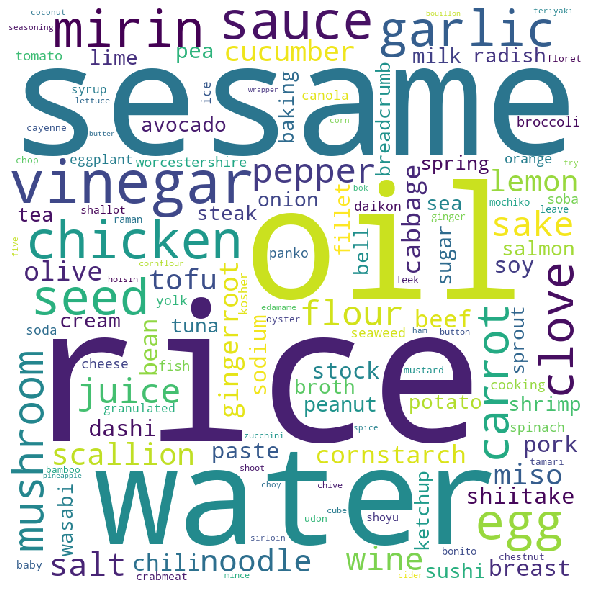

In [809]:
plt_wordcloud(data)

#### Italy's popular ingredients for cooking

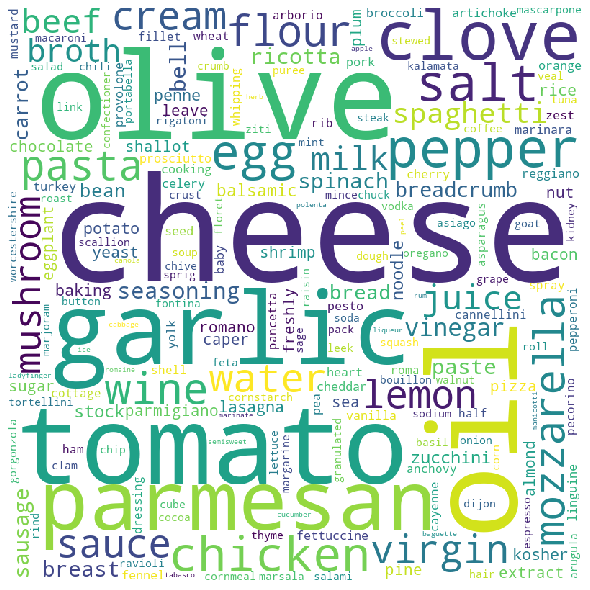

In [811]:
data = recipe_country_ingreds[recipe_country_ingreds['country'] == 'Italy']['ingredients'].values
plt_wordcloud(data)

The wordclouds shown above seem to be in line with common sense. 

In the japanese recipes, we can notice some typical east-asian ingredients such as rice, sauce, sesame and tofu and at the same time some japanese specialties emerge: mirin(an essential condiment used in Japanese cuisine. It is a type of rice wine similar to sake, but with a lower alcohol content and higher sugar content.) and sake(a japanese traditional rice wine).

Similarly, in italian recipes, different kinds of cheese(parmesan cheese and mozzarella cheese), olive, spaghetti and pasta are largely present. They particularly love parmesan cheese as it appears in 35% of the italien recipes. 

Cloudword images on some more countries can be found in our data story.

## 1.6 Drawing the choropleth map of the nutrition facts

Nutrition in the diet has a direct impact on people's health. We draw here a choropleth map based on the average nutrition facts of the dishes from different countries.

In [812]:
avg_nutrition = recipe_country.groupby("country").mean()

In [813]:
avg_nutrition = avg_nutrition[nutritions_list].reset_index()

In [814]:
avg_nutrition.head()

,country,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
0,Argentina,533.674194,51.887097,34.104839,26.814516,43.782258,45.637097,10.887097
1,Australia,473.954699,36.583949,82.931714,20.187962,34.920803,47.578317,15.264696
2,Austria,607.671765,46.129412,121.288235,21.541176,34.335294,59.923529,22.076471
3,Belgium,523.245455,44.915152,52.412121,20.327273,44.109091,58.812121,13.054545
4,Brazil,437.537247,35.076923,71.072874,19.870445,34.850202,39.761134,12.097166


In [815]:
import geopandas
from matplotlib import cm

In [816]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [817]:
avg_nutrition = avg_nutrition[~avg_nutrition.country.isin(['Caribbean', 'Hawaii', 'Melanesia', 'Polynesia'])].reset_index(drop=True)

In [818]:
merged = world.set_index('name').join(avg_nutrition.set_index('country'))

In [819]:
def plot_nutrition(column):
    # plot as usual, grab the axes 'ax' returned by the plot
    colormap = "OrRd"   # add _r to reverse the colormap
    ax = merged.plot(color="grey", figsize=(12, 9))
    ax2 = merged.dropna().plot(ax=ax, column=column, cmap=colormap, figsize=[12,9])

    # map marginal/face deco
    ax2.set_title("Average " + column + " in recipes from different countries" + \
                  "\n (missing values are plotted in grey)")

    # colorbar will be created by ...
    fig = ax2.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title(column)

    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(merged[column].dropna()), vmax=max(merged[column].dropna())))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes

    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")

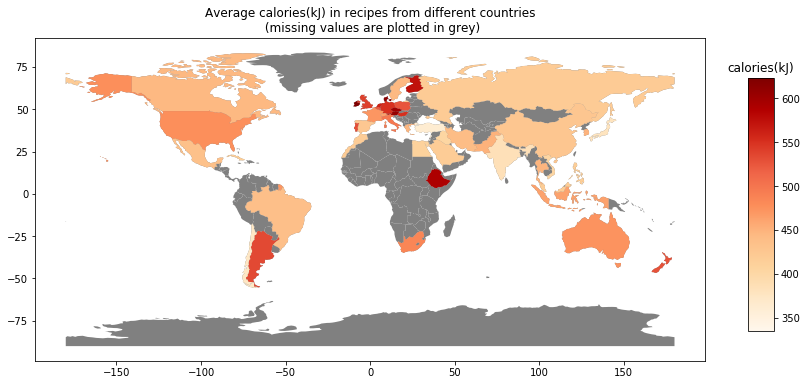

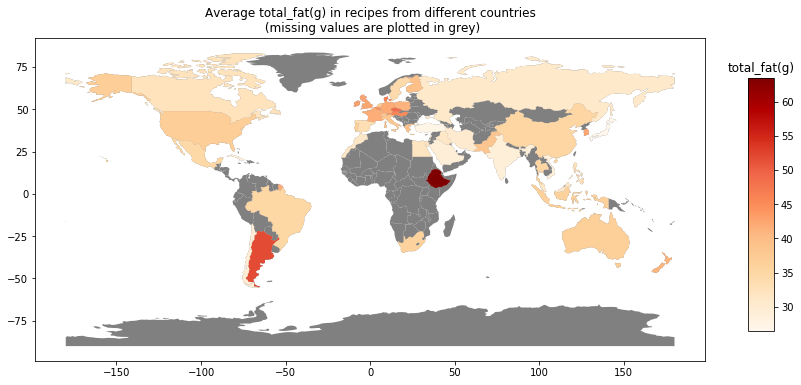

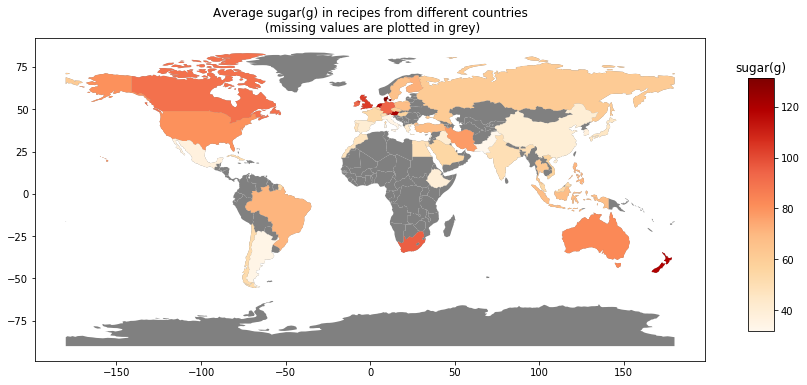

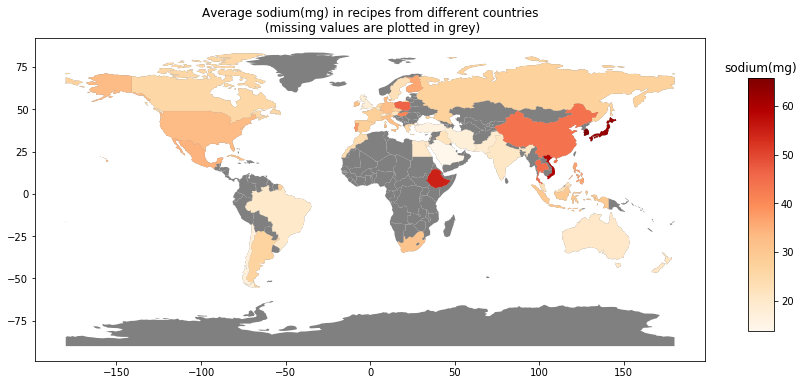

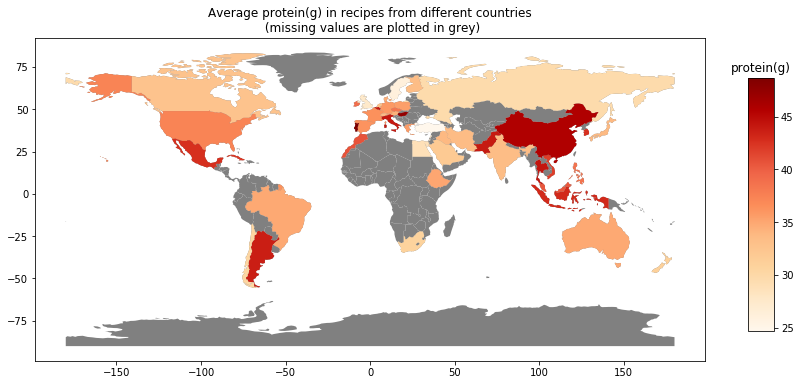

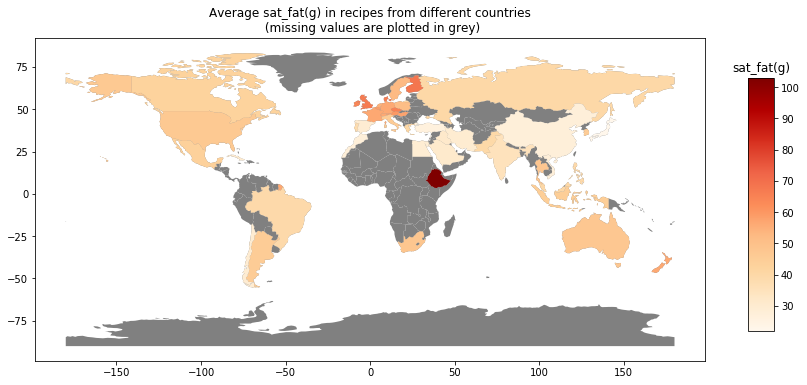

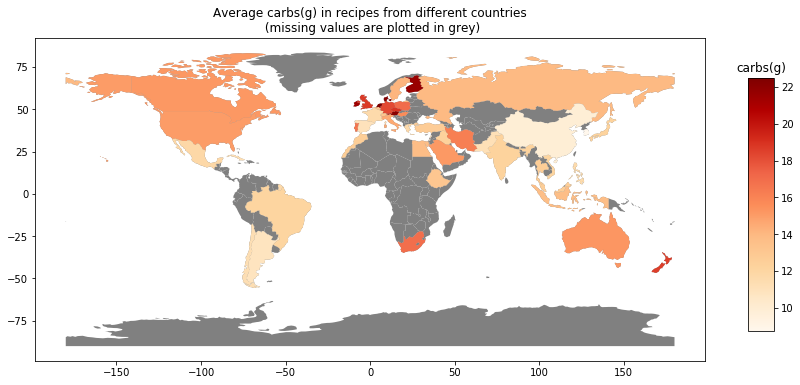

In [820]:
for column in nutritions_list:
    plot_nutrition(column)

Clearly, recipes originated from western countries tend to contain relatively high calories, carbs and saturated fat while those from eastern countries tend to contain high sodium and high proteins.

# 2. Incoporating WHO dataset

We read in some health statistics from WHO. Since the most recent available data related to diseases are those collected in 2016, for the sake of coherence, we use 2016 version of other statistics. The first one to read in is the life span.

In [75]:
health_data= pd.read_csv('data/RAW_lifespan.csv')
health_data = health_data[health_data['Indicator']=='Life expectancy at birth (years)']
health_data = health_data[health_data['Dim1'] == 'Both sexes']
health_data.drop(columns=['Indicator','Period','Dim1'],inplace=True)
health_data.rename(columns={'First Tooltip':'Life span'},inplace=True)
health_data.reset_index(drop=True, inplace=True)

Then we add some food-related common health indices which includes 'overweight', 'blood_pressure', 'blood_glucose', 'cholesterol' from the data download from WHO website. The data shows the percentage of total population in a country suffering from these common diseases and NCD death rate (non-communicable diseases, including Malignant neoplasms, Diabetes mellitus, Cardiovascular diseases, Chronic obstructive pulmonary disease) in different countries.

In [76]:
dataset_list = ['data_overweight.csv', 'data_blood_glucose.csv', 'data_blood_pressure.csv', 
                'data_cholesterol.csv', 'data_NCD_death.csv']
column_names = ['Overweight(%)', 'High Blood Glucose(%)', 'High Blood Pressure(%)', 'High Cholesterol(%)',
                'NCD death probability(%)']

In [77]:
for ind, dataset in enumerate(dataset_list):
    data_sub = pd.read_csv(os.path.join('data', dataset))
    data_sub.rename(columns={'First Tooltip':column_names[ind]}, inplace=True)
    health_data = health_data.merge(data_sub[['Location',column_names[ind]]])

In [78]:
cols = ['Overweight(%)','High Blood Glucose(%)','High Blood Pressure(%)','High Cholesterol(%)']
for c in cols:
    health_data[c]=health_data[c].str.split('[',expand=True)[0].astype('float')

We further add the death rate due to some specific disease types in a country. To calculate the incidence rate, we also import the population of different countries.

In [79]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]

In [80]:
data_pop= pd.read_csv('data/data_population.csv')
data_pop = data_pop[data_pop['Time']==2016][['Location','PopTotal']]
health_data = pd.merge(health_data, data_pop)
health_data.rename(columns={'PopTotal': 'PopTotal(k)'}, inplace=True)

In [81]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]
data_disease= pd.merge(data_disease,data_pop,on='Location')
data_disease['disease(%)']=data_disease['First Tooltip']/data_disease['PopTotal']/10

In [82]:
diseases = ['Malignant neoplasms','Diabetes mellitus','Cardiovascular diseases','Chronic obstructive pulmonary disease']
for d in diseases:
    data_sub=data_disease.loc[data_disease['Dim2']==d].copy()
    data_sub.rename(columns={'disease(%)':d+' death(%)'},inplace=True)
    health_data=pd.merge(health_data,data_sub[['Location',d+' death(%)']],on='Location')

The GNI per capita is the dollar value of a country's final income in a year, divided by its population. It should be reflecting the average before tax income of a country's citizens. In particular, a country's GNI per capita tends to be closely linked with other indicators of public health of a country. For example the life span in wealthy countries is usually higher than poorer ones. The data comes from world bank: https://data.worldbank.org/indicator/NY.GNP.PCAP.CD and according to the criterion given by world bank (see the table below), the countries are divided into different groups (High-income, Upper-middle-income, Lower-middle-income, Low-income). Again we use data in 2016.

| Thresholds    |  GNI/Capita (current US$)|
| ------------- |:-------------:|
| Low-income    | < 1006 |
| Lower-middle income     | 1,006 - 3,955     |
| Upper-middle income | 3,956 - 12,235      |
|High-income    | > 12,235|

In [83]:
data_gni=pd.read_csv('data/GNI_per_capita.csv')
data_gni=data_gni[['Country Name','2016']]
data_gni.rename(columns={'Country Name':'Location','2016':'GNP per capita($)'},inplace=True)

In [84]:
health_data = pd.merge(health_data,data_gni,on='Location')

In [85]:
health_data.dropna(inplace=True)
health_data.reset_index(drop=True, inplace=True)

In [128]:
health_data['income group'] = np.nan

In [129]:
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] < 1006].index] = 'low'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 1006)
                                              & (health_data['GNP per capita($)'] < 3955)].index] = 'lower-middle'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 3956)
                                              & (health_data['GNP per capita($)'] < 12235)].index] = 'upper-middle'
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] > 12235].index] = 'high'

In [130]:
health_data.rename(columns={'Location': 'country'},inplace=True)

# 3. Relationship between eating habits and health

Recipes reflect the eating habits of a country. In the following, based on the data collected from recipes, we study the relation between nutrition in food and health indices as well as relation between ingredients + cooking methods with health indices to identify good eating and cooking practices that are beneficial to one's health.

## 3.1 Nutrition in food v.s. health indices

In essence, the significance of eating is to provide nutrition to our body so that it can go on functioning. Therefore, the nutrition in food should have a direct impact on health.

In [131]:
nutrition_health = pd.merge(health_data, avg_nutrition, on='country')
nutrition_health.head()

,country,Life span,Overweight(%),High Blood Glucose(%),High Blood Pressure(%),High Cholesterol(%),NCD death probability(%),PopTotal(k),Malignant neoplasms death(%),Diabetes mellitus death(%),...,Chronic obstructive pulmonary disease death(%),GNP per capita($),income group,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
0,Angola,62.63,27.5,8.2,29.7,30.9,16.5,28842.482,0.029314,0.008248,...,0.012489,3770.0,lower-middle,362.830769,28.076923,58.461538,18.769231,32.692308,32.307692,10.846154
1,Argentina,76.95,62.7,9.7,22.6,50.5,15.8,43508.459,0.150906,0.021221,...,0.079123,12220.0,upper-middle,533.674194,51.887097,34.104839,26.814516,43.782258,45.637097,10.887097
2,Australia,82.90,64.5,5.9,15.2,55.2,9.1,24262.710,0.188557,0.019594,...,0.048379,54190.0,high,473.585870,36.557821,82.864675,20.169420,34.888928,47.525483,15.252724
3,Austria,81.87,54.3,4.3,21.0,59.7,11.4,8747.306,0.238919,0.038892,...,0.046963,46130.0,high,607.671765,46.129412,121.288235,21.541176,34.335294,59.923529,22.076471
4,Belgium,81.16,59.5,4.6,17.5,62.4,11.4,11354.407,0.253708,0.014822,...,0.076164,42530.0,high,523.245455,44.915152,52.412121,20.327273,44.109091,58.812121,13.054545


In [133]:
nutrition_health.groupby('income group').count()['country']

income group
high            23
low              2
lower-middle    10
upper-middle    13
Name: country, dtype: int64

In [121]:
corr = nutrition_health.corr()
corr

,Life span,Overweight(%),High Blood Glucose(%),High Blood Pressure(%),High Cholesterol(%),NCD death probability(%),PopTotal(k),Malignant neoplasms death(%),Diabetes mellitus death(%),Cardiovascular diseases death(%),Chronic obstructive pulmonary disease death(%),GNP per capita($),calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,1.000000,0.591809,-0.385441,-0.818796,0.850515,-0.818057,-0.154184,0.781950,-0.074608,0.264136,0.554877,0.758390,-0.019346,-0.201545,0.105705,-0.034275,-0.274183,0.023903,0.231150
Overweight(%),0.591809,1.000000,0.213889,-0.470747,0.528459,-0.409011,-0.426471,0.361868,0.146544,0.180265,0.084977,0.376128,-0.110066,-0.256731,0.006464,-0.401622,-0.283514,-0.178871,0.169016
High Blood Glucose(%),-0.385441,0.213889,1.000000,0.298977,-0.438992,0.481823,0.035347,-0.582748,0.125788,-0.107768,-0.508581,-0.602868,-0.549179,-0.443209,-0.385285,-0.268511,-0.061136,-0.620778,-0.403770
High Blood Pressure(%),-0.818796,-0.470747,0.298977,1.000000,-0.635239,0.719545,0.019705,-0.458621,0.044468,0.026962,-0.422896,-0.668382,0.182386,0.321737,-0.207238,0.184875,0.400406,0.098870,-0.143934
High Cholesterol(%),0.850515,0.528459,-0.438992,-0.635239,1.000000,-0.658726,-0.298753,0.794864,0.062000,0.281450,0.531847,0.780290,0.128170,-0.129554,0.208579,0.073553,-0.138658,0.179748,0.371017
NCD death probability(%),-0.818057,-0.409011,0.481823,0.719545,-0.658726,1.000000,0.212025,-0.557548,0.156168,0.082165,-0.379916,-0.742875,-0.093326,-0.003314,-0.144050,0.149312,0.373968,-0.144323,-0.234070
PopTotal(k),-0.154184,-0.426471,0.035347,0.019705,-0.298753,0.212025,1.000000,-0.143008,-0.028350,-0.012487,0.222973,-0.220627,-0.173991,-0.099900,-0.166203,0.082833,0.087426,-0.173515,-0.231077
Malignant neoplasms death(%),0.781950,0.361868,-0.582748,-0.458621,0.794864,-0.557548,-0.143008,1.000000,-0.039599,0.571538,0.756594,0.670274,0.264921,0.069742,0.173582,0.237852,-0.049537,0.248687,0.353023
Diabetes mellitus death(%),-0.074608,0.146544,0.125788,0.044468,0.062000,0.156168,-0.028350,-0.039599,1.000000,0.110967,0.082634,-0.176107,0.010154,-0.045355,0.062231,-0.054953,0.031003,-0.013914,0.080036
Cardiovascular diseases death(%),0.264136,0.180265,-0.107768,0.026962,0.281450,0.082165,-0.012487,0.571538,0.110967,1.000000,0.436873,0.113601,0.026866,0.006224,-0.135933,0.106124,-0.004866,0.075720,0.024643


In [136]:
nutri_heal_upper = nutrition_health[nutrition_health['income group']=='upper-middle'].drop(columns = ['GNP per capita($)','income group','PopTotal(k)'])
corr = nutri_heal_upper.corr()
corr.iloc[:10,11:]

,total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,-0.094489,-0.758104,-0.123344,-0.241802,-0.331398,-0.893454
Overweight(%),-0.236477,-0.296466,-0.739028,-0.676605,-0.417754,-0.259595
High Blood Glucose(%),-0.467102,-0.207516,-0.437397,-0.505322,-0.491112,-0.175369
High Blood Pressure(%),0.238220,0.719123,0.019791,0.314213,0.434412,0.850625
High Cholesterol(%),0.278847,-0.406516,0.138065,0.150344,0.440987,-0.362940
NCD death probability(%),0.048282,0.607396,0.059817,0.073591,0.196046,0.670311
Malignant neoplasms death(%),0.333663,-0.269826,0.303307,-0.016924,0.010188,-0.541603
Diabetes mellitus death(%),0.146073,0.310600,0.292201,0.100671,0.530405,0.389659
Cardiovascular diseases death(%),0.093381,-0.277337,0.268699,0.021818,-0.314051,-0.457089
Chronic obstructive pulmonary disease death(%),0.743509,-0.081122,0.457906,0.355492,0.344972,-0.191764


In [137]:
nutri_heal_high = nutrition_health[nutrition_health['income group']=='high'].drop(columns = ['GNP per capita($)','income group','PopTotal(k)'])
corr = nutri_heal_high.corr()
corr.iloc[:10,11:]

,total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,-0.118066,0.041935,0.092570,-0.176838,0.006591,-0.114971
Overweight(%),0.160958,0.088013,-0.706930,0.020629,0.170352,0.031947
High Blood Glucose(%),-0.421698,-0.294500,-0.182110,-0.078474,-0.535559,-0.240336
High Blood Pressure(%),0.255541,-0.223397,0.329120,0.444333,0.058526,0.059407
High Cholesterol(%),0.333851,0.197351,0.358863,0.173707,0.477643,0.223845
NCD death probability(%),0.296728,-0.040211,0.131726,0.355207,0.077295,0.094461
Malignant neoplasms death(%),0.431069,0.009762,0.604046,0.455030,0.249463,0.087378
Diabetes mellitus death(%),0.334444,0.120909,-0.021459,0.484130,0.030134,0.188547
Cardiovascular diseases death(%),0.444475,-0.149638,0.423107,0.455232,0.239119,0.074970
Chronic obstructive pulmonary disease death(%),0.202065,-0.082886,0.390727,0.384098,-0.106461,-0.122575


In [138]:
nutri_heal_lower = nutrition_health[nutrition_health['income group']=='lower-middle'].drop(columns = ['GNP per capita($)','income group','PopTotal(k)'])
corr = nutri_heal_lower.corr()
corr.iloc[:10,11:]

,total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,0.195884,-0.025074,-0.053083,0.042136,-0.187507,0.304587
Overweight(%),-0.151003,-0.424285,-0.097330,0.235440,-0.596674,-0.025954
High Blood Glucose(%),-0.108941,-0.733516,-0.251249,0.149946,-0.557276,-0.405729
High Blood Pressure(%),-0.295253,-0.400324,0.076599,0.239063,-0.243012,-0.433702
High Cholesterol(%),-0.146027,-0.212175,0.231247,0.176995,-0.136614,-0.316864
NCD death probability(%),-0.029246,-0.198578,0.448566,0.415565,0.302202,-0.235462
Malignant neoplasms death(%),-0.089569,-0.316905,0.270881,0.200197,0.044009,-0.263721
Diabetes mellitus death(%),0.264189,-0.193207,-0.335086,-0.442355,0.296374,-0.333921
Cardiovascular diseases death(%),-0.051279,-0.452545,-0.151785,-0.282548,0.097528,-0.599114
Chronic obstructive pulmonary disease death(%),-0.019714,-0.211025,-0.309999,-0.510901,0.277840,-0.366193


## 3.2 Ingredients and cooking methods v.s. health indices

# 4. simlimiarty
In this section, we want to ask how different recipes are related. We will define several simimilarity between  recipes based on ingredients and steps

In [88]:
recipe_country = pd.read_pickle('data/recipe_country.pkl')

In [828]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a]=1
    return d

In [829]:
target_country = recipe_country[:1000].country.value_counts()[:10].index.values
target_country

array(['United States of America', 'Mexico', 'Italy', 'Canada', 'India',
       'Australia', 'France', 'United Kingdom', 'China', 'Iran'],
      dtype=object)

In [842]:
mask = recipe_country[:1000]['country'].apply(lambda x: x in target_country)
df_tiny = recipe_country[:1000][mask][['country', 'ingredients']]

In [843]:
# One hot encoding of the ingredients
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(
    df_tiny.ingredients.apply(convert_to_dict)
)

In [844]:
# Apply TSNE 
X_tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, metric='jaccard').fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 890 samples in 0.017s...
[t-SNE] Computed neighbors for 890 samples in 0.713s...
[t-SNE] Computed conditional probabilities for sample 890 / 890
[t-SNE] Mean sigma: 0.254002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.562302
[t-SNE] Error after 500 iterations: 1.001498


In [845]:
df_res = pd.DataFrame(data = X_tsne, columns = ['tsne-1', 'tsne-2'])
df_res['y'] = df_tiny['country']

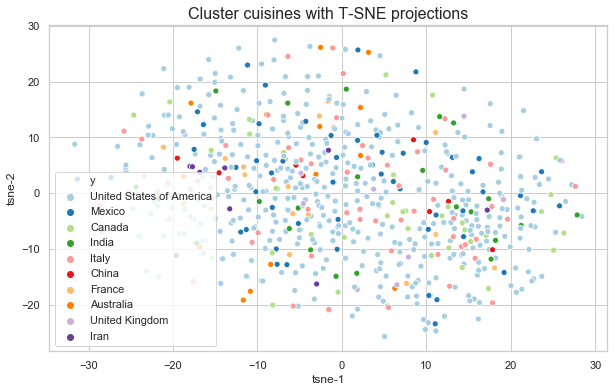

In [846]:
# Plotting the clusters on with t-sne projections
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.scatterplot("tsne-1", "tsne-2", data=df_res, palette='Paired', hue='y')
plt.title('Cluster cuisines with T-SNE projections', fontsize=16)
plt.show()